This is my first attempt at creating and training my own neural network. I'll be training my model on the MNIST dataset to recognize numbers 0-9. This will be a convolutional neural network built from scratch. The problem is simple enough to not really need a pretrained base model.


I may try to expand this project to include a drawing board where users can draw their own numbers and have my model predict them.

# Imports #

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

SEED = 31415

# Loading Data #

In [2]:
df_train = pd.read_csv("../input/digit-recognizer/train.csv")
print(df_train.shape)
df_train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv("../input/digit-recognizer/test.csv")
print(df_test.shape)
df_test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each image is represented using 784 features. Each feature represents a pixel in a 28\*28 grid. The pixels are numbered left to right, top to bottom where the top left pixel is pixel0 and the pixel directly below it is pixel28. The `label` feature in the training data is the represented number.

Each pixel can have a value from 0-255 where 0 is black and 255 is white.

# Data Analysis #



In [4]:
print("Missing values:")
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())
print("------------------")
print(df_train.dtypes.value_counts())
print(df_test.dtypes.value_counts())

Missing values:
0
0
------------------
int64    785
Name: count, dtype: int64
int64    784
Name: count, dtype: int64


The dataset has no missing values and all columns are appropriately encoded as type `int64`. This reduces the amount of preprocessing needed.

<Axes: xlabel='label', ylabel='count'>

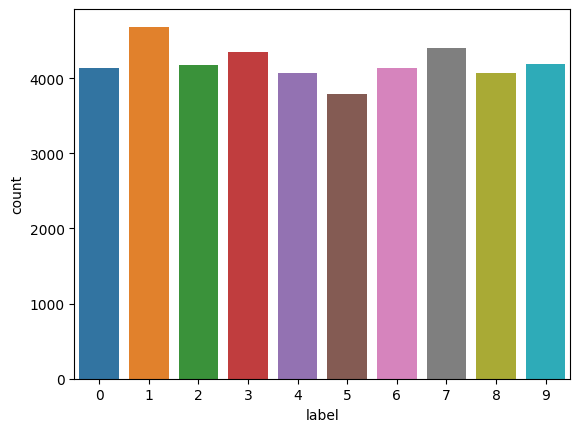

In [5]:
sns.countplot(x="label", data=df_train)

We have a fairly even distribution of numbers within the training set.

# Preprocessing #

We normalize the data and reshape it so that the CNN can handle it. 

In [6]:
X_train = df_train.copy()
y_train = X_train.pop("label")
X_test = df_test.copy()

#Normalize data
X_train = X_train / 255
X_test = X_test / 255

#Reshape data, 28x28, 1 channel
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

Here's a look at the first couple entries of our training data

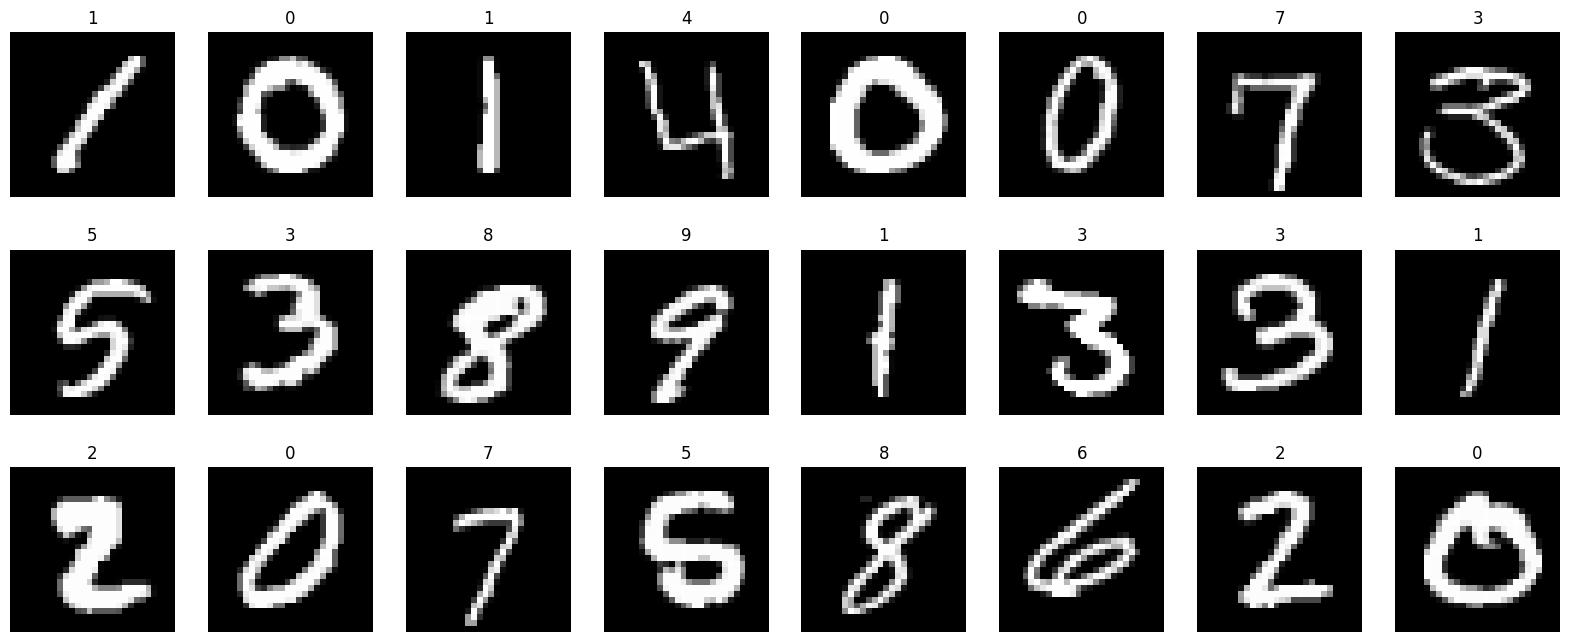

In [7]:
#Display first n X_train entries
n_rows, n_cols = 3, 8
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))
axs = axs.flatten()
for i in range(n_rows*n_cols):
    axs[i].imshow(X_train[i], cmap="gray") 
    axs[i].set_title(y_train[i])
    axs[i].axis("off")

One-hot encoding the target also helps the CNN training. 

In [8]:
#e.g. 4 becomes [0,0,0,0,1,0,0,0,0,0]
y_train = to_categorical(y_train, num_classes=10)

Now, we'll extract our validation data from our training data. Given that the dataset is relatively large, we'll use 10% of the training data as validation.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Model Creation and Training #

To create the convolutional base, I opted for 3 blocks with batch normalization, same padding, and global pooling. Same padding is important since the images are already low resolution and border values seem to mainly be 0. Global pooling and batch normalization should help reduce overfitting and allow the model to capture the overall patterns.

In [10]:
model = keras.Sequential([
    layers.InputLayer(shape=[28, 28, 1]),
    
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,618 (861.79 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 192 (768.00 B)

Compile the model using Adam optimization

In [11]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [12]:
epochs = 10
batch_size = 64 

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1 )

Epoch 1/10


I0000 00:00:1725093289.964586      67 service.cc:145] XLA service 0x7d9f7400d2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725093289.964640      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 57/591 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6014 - loss: 1.3022

I0000 00:00:1725093293.814681      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8641 - loss: 0.4332 - val_accuracy: 0.9750 - val_loss: 0.0840
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9751 - loss: 0.0805 - val_accuracy: 0.9802 - val_loss: 0.0602
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9822 - loss: 0.0587 - val_accuracy: 0.9733 - val_loss: 0.0985
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9877 - loss: 0.0393 - val_accuracy: 0.9821 - val_loss: 0.0648
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9845 - val_loss: 0.0635
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9889 - loss: 0.0344 - val_accuracy: 0.9871 - val_loss: 0.0568
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9927 - loss: 0.0229 - val_accuracy: 0.9871 - val_loss: 0.0515
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9926 - loss: 0.0218 - val_accuracy: 0.9812 - val

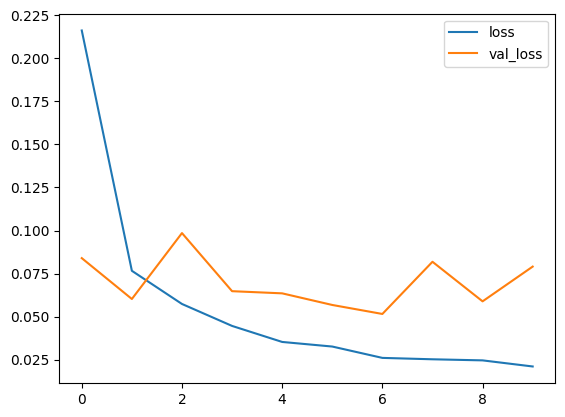

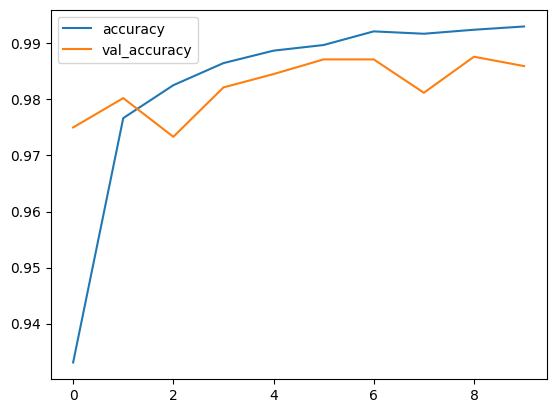

In [13]:
df_history = pd.DataFrame(history.history)
df_history.loc[:, ['loss', 'val_loss']].plot()
df_history.loc[:, ['accuracy', 'val_accuracy']].plot();